## Heart Disease prediction system

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
import shap
import os

os.makedirs('outputs', exist_ok=True)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print('Everything looks good')


Everything looks good


In [51]:
df = pd.read_csv('archive/heart.csv')
df.columns = df.columns.str.strip()
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


* EDA with Graphs

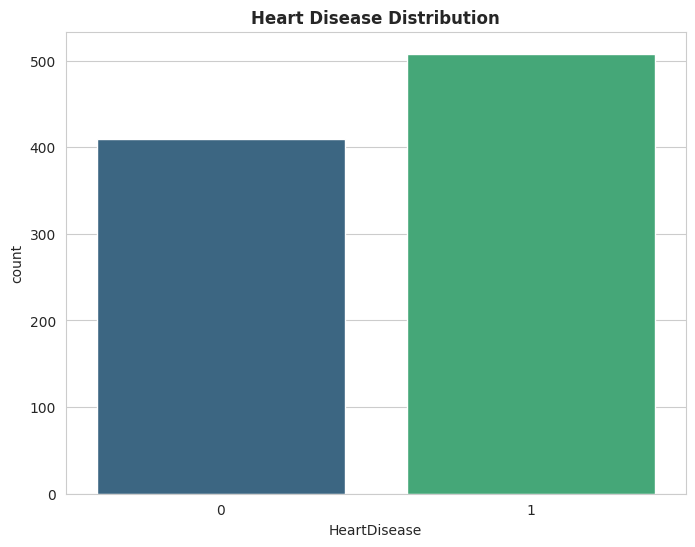

In [52]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='HeartDisease', palette='viridis')
plt.title('Heart Disease Distribution', fontweight='bold')
plt.savefig('outputs/graph1_target.png', dpi=300)
plt.show()

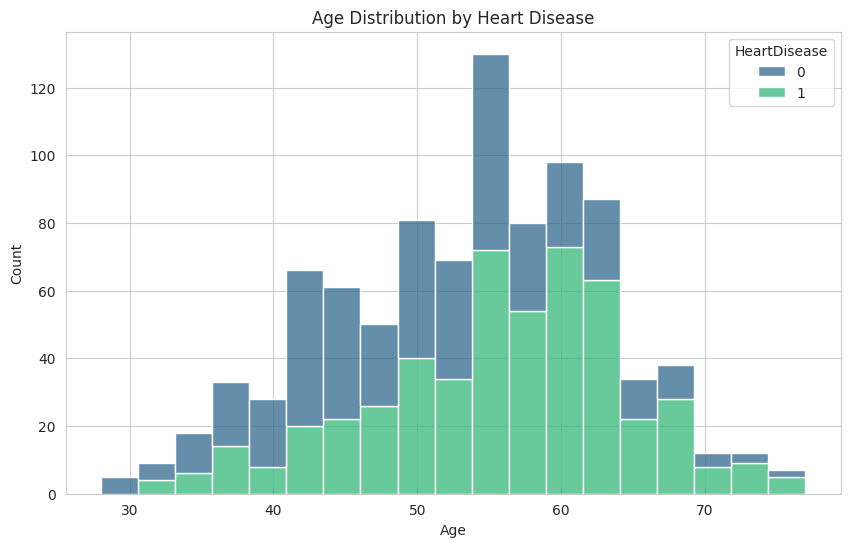

In [53]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Age', hue='HeartDisease', multiple='stack', palette='viridis')
plt.title('Age Distribution by Heart Disease')
plt.savefig('outputs/graph2_age_hd.png', dpi=300)
plt.show()

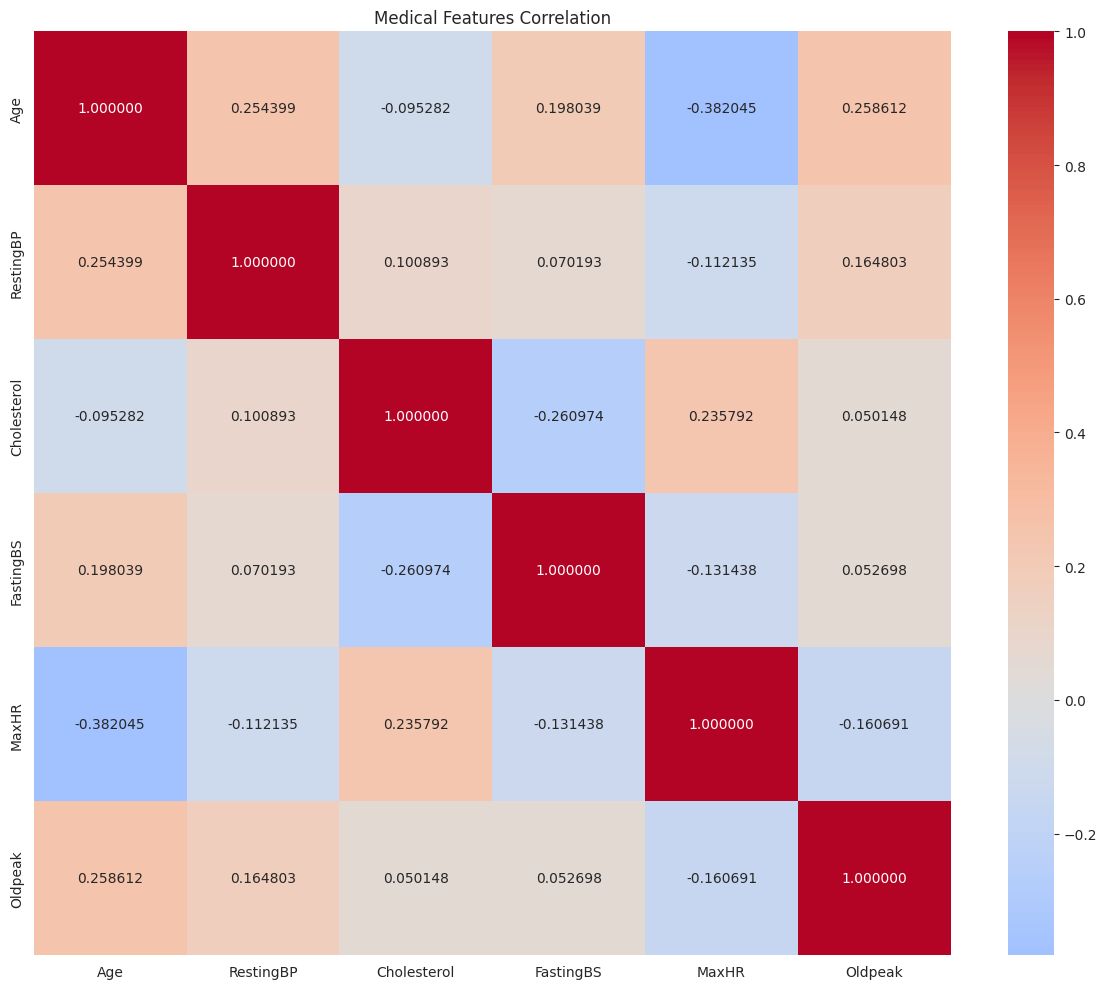

In [54]:
plt.figure(figsize=(12,10))
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('HeartDisease')
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0, fmt='2f')
plt.title('Medical Features Correlation')
plt.tight_layout()
plt.savefig('outputs/graph3_correlation.png', dpi=300)
plt.show()


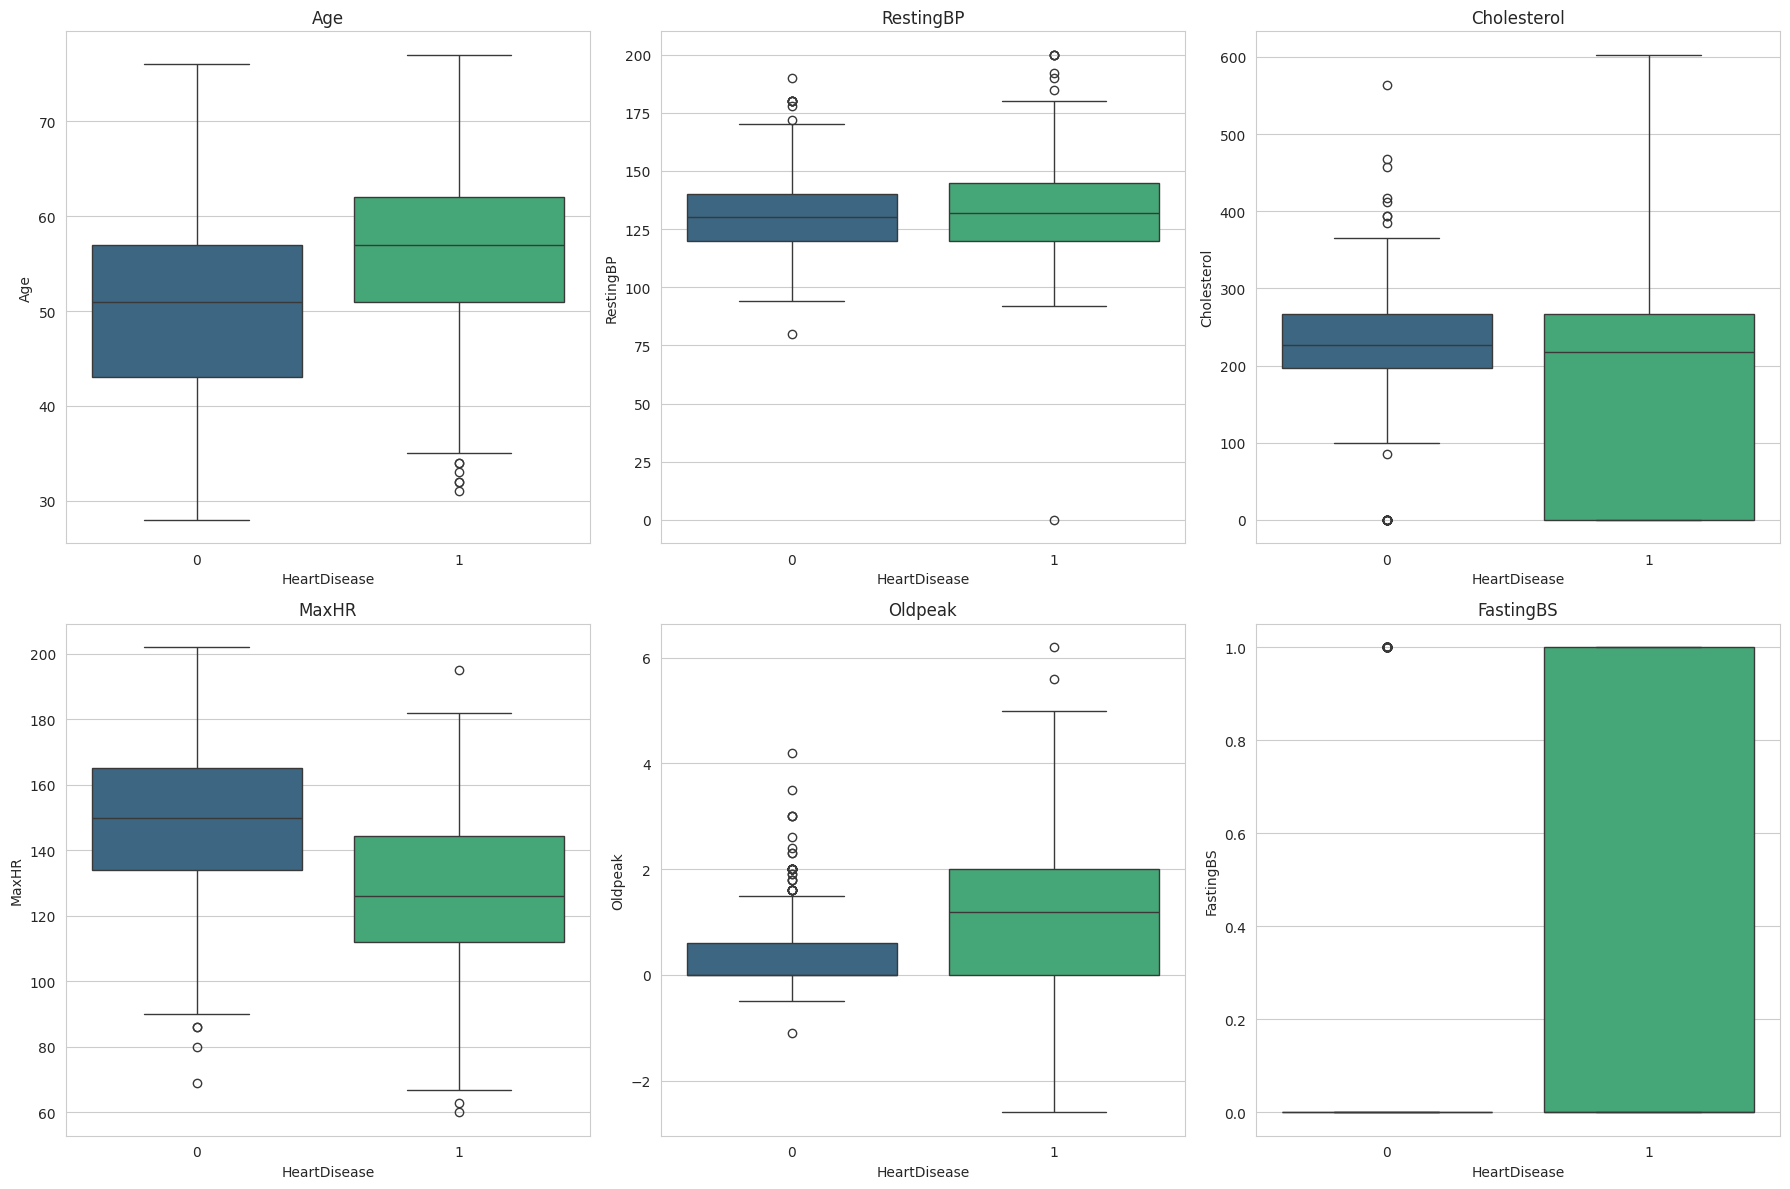

In [55]:
fig, axes = plt.subplots(2,3, figsize=(18,12))
key_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS']
for i, feature in enumerate(key_features):
    row, col = i//3, i%3
    sns.boxplot(data=df, x="HeartDisease", y=feature, ax=axes[row,col], palette='viridis')
    axes[row,col].set_title(f'{feature}')
plt.tight_layout()
plt.savefig('outputs/graph4_features.png', dpi=700)
plt.show()


In [56]:
df['risk_score'] = (
    (df['Age'] >= 55).astype(int) +
    (df['RestingBP'] >= 140).astype(int) +
    (df['Cholesterol'] >= 240).astype(int) +
    (df['FastingBS'] >= 1).astype(int) +
    (df['Oldpeak'] >= 2.0).astype(int)
)

df['Sex'] = df['Sex'].map({'F': 0, 'M': 1})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'N':0, 'Y':1}).fillna(0)

cat_cols = ['ChestPainType', 'RestingECG', 'ST_Slope']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


* Splitting and Testing Data

In [57]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

print(f" Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")


 Train: (812, 16), Test: (184, 16)


* Training

In [58]:
models = {
    "Logistic": LogisticRegression(random_state=42),
    "RandomForest" : RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost" : XGBClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train_bal)
    y_proba = model.predict_proba(X_test_scaled)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"{name}: AUC {auc:.3f}")
    results[name] = {'model': model,'auc': auc}

best_name = max(results, key=lambda x: results[x]['auc'])
best_model = results[best_name]['model']
print(f"\n Best: {best_name} (AUC: {results[best_name]['auc']:.3f})")

Logistic: AUC 0.926
RandomForest: AUC 0.939
XGBoost: AUC 0.929

 Best: RandomForest (AUC: 0.939)


* SHAP


In [59]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

<Figure size 1000x800 with 0 Axes>

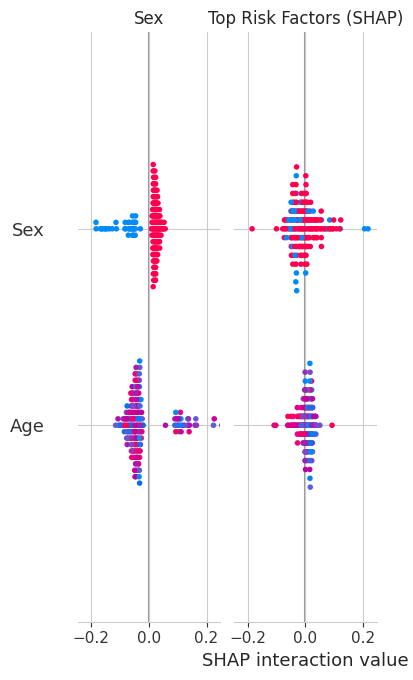

In [60]:
plt.figure(figsize=(10,8))
shap.summary_plot(shap_values, X_test_scaled, X.columns, plot_type='bar', show=False)
plt.title('Top Risk Factors (SHAP)')
plt.savefig('outputs/graph5_shap_importance.png', dpi=300)
plt.show()

<Figure size 1000x800 with 0 Axes>

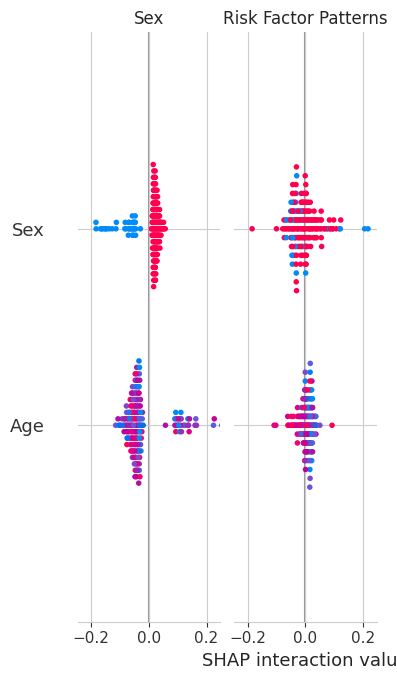

In [61]:
plt.figure(figsize=(10,8))
shap.summary_plot(shap_values, X_test_scaled, X.columns, show=False)
plt.title('Risk Factor Patterns')
plt.savefig('outputs/graph6_shap_summary.png', dpi=300)
plt.show()

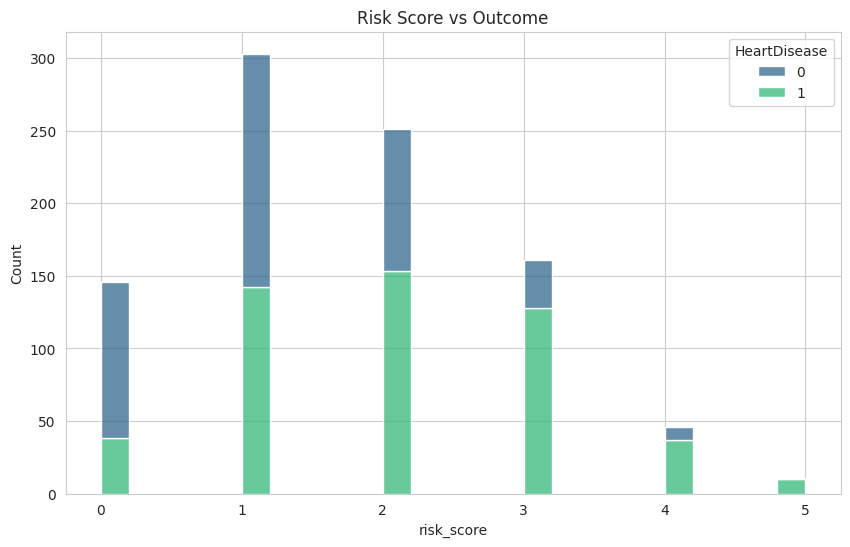

In [62]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='risk_score', hue='HeartDisease', multiple='stack', palette='viridis')
plt.title('Risk Score vs Outcome')
plt.savefig('outputs/graph7_risk_score.png', dpi = 700)
plt.show()

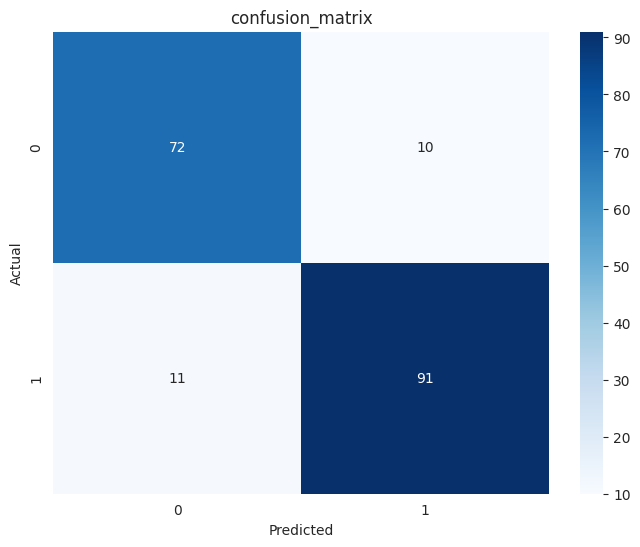

In [63]:
y_pred = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('confusion_matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('outputs/graph8_confusion.png', dpi=700)
plt.show()

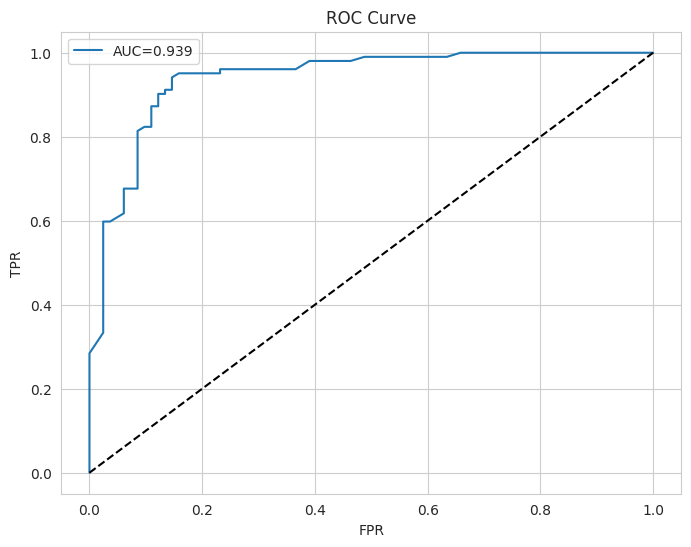

In [64]:
from sklearn.metrics import roc_curve
y_proba = best_model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _= roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC={results[best_name]["auc"]:.3f}')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve')
plt.legend()
plt.savefig('outputs/graph9_roc.png', dpi=700)
plt.show()

In [65]:
print("\n    INSIGHTS")
print(f"Patients: {len(df)} | Disease rate: {df['HeartDisease'].mean()*100:.1f}%")
print(f"High risk (score≥3): {len(df[df['risk_score']>=3])}")
print(f"Best model: {best_name} AUC {results[best_name]['auc']:.3f}")
print("outputs/ folder ready ")



    INSIGHTS
Patients: 918 | Disease rate: 55.3%
High risk (score≥3): 218
Best model: RandomForest AUC 0.939
outputs/ folder ready 
